# 医用画像の超解像

---


超解像は、低解像度の画像をより鮮明にするために、画像の質を向上させることを目的とした技術です。

このプロセスは、画像処理の分野で広く研究されています。しかし、研究者がしばしば遭遇するいくつかの問題があります。 一つは、補間を利用した手法に関する問題です。補間ベースの技術は、利用可能な情報を使い、知識や経験に基づいた推測を行うことで、低解像度の画像に欠けている詳細を推定しようとします。残念ながら、このような手法では、強調された画像にシャープさや細かいディテールがなく、ぼやけた出力になってしまうことがしばしばあります。

Stable Diffusion は、AI アルゴリズムを使用して画像のスケールを拡大するため、画像内のギャップを手動で埋めるような作業が不要になります。数百万枚の画像でトレーニングされ、高解像度の画像を正確に予測できるため、従来の画像アップスケーラーと比較してディテールが大幅に向上します。さらに、最近傍などの非深層学習技術とは異なり、Stable Diffusionは画像のコンテキストを考慮し、スケールの拡大プロセスを導くために、テキストのプロンプトを使用します。

このノートブックでは、デモンストレーションとして、CT スキャンで取得した画像を強化する方法を紹介します。

こちらは、中足骨を骨折した、犬の足の CT スキャンです。

<img src="ctscan_dog.png" alt= "CT Scan Dog Paws" align="center">

SageMaker Python SDK を使用して、最先端の事前学習された Stable Diffusion モデルを用いてアップスケーリングを行います。アップスケーリングは、低解像度の画像と画像を説明するテキストプロンプトが与えられた場合に、高解像度の画像を生成するタスクです。低解像度でぼやけており、ピクセル化してしまった画像を、より滑らで、鮮明で詳細な高解像度画像に変換することができます。アップスケーリングと呼ぶこのプロセスは、実際の画像でも [text-to-image Stable Diffusion モデル](https://aws.amazon.com/blogs/machine-learning/generate-images-from-text-with-the-stable-diffusion-model-on-amazon-sagemaker-jumpstart/) によって生成された画像のどちらにも適用できます。

医療分野では、診断の改善と、放射線学で普及している CAD（Computer Aided Detection）システムによる検出をより強化する目的で、画質を向上させようとする研究が数多く行われています。さらに、アップスケーリングは、高解像度な画面に表示される低解像度画像の視覚的な品質を向上させることができます。

---

1. [セットアップ](#1.-セットアップ)
2. [Artifacts の取得とエンドポイントのデプロイ](#2.-Artifactsの取得とエンドポイントのデプロイ)
3. [エンドポイントへのクエリとレスポンスのパース](#3.-エンドポイントへのクエリとレスポンスのパース)
4. [エンドポイントのクリーンアップ](#4.-エンドポイントのクリーンアップ)

Note: このノートブックは Amazon SageMaker Studio の ml.t3.medium インスタンスとPython 3 (Data Science) カーネルを使用した環境、及び Amazon SageMaker Notebook インスタンスの　conda_python3 カーネルの環境でテストしました。

Note: ノートブックの実行が終わったら、全てのリソースを必ず削除して、課金が停止するようにしてください。[エンドポイントのクリーンアップ](#4.-エンドポイントのクリーンアップ) のコードは、作成されたモデルとエンドポイントを削除します。

### 1. セットアップ

---
ノートブックを実行する前に、セットアップのためにいくつかの初期ステップがあります。このノートブックでは最新版の sagemaker および ipywidegets が必要です。

---

In [2]:
!pip install sagemaker ipywidgets --upgrade --quiet

#### 権限と環境変数

---
Amazon SageMaker でモデルをホストするために、AWS サービスを利用するための権限をセットアップする必要があります。ここでは、SageMaker にアクセスできる AWS アカウントのロールとして、ノートブックに関連づけられた実行ロールを利用します。

---

In [3]:
import boto3
import matplotlib.pyplot as plt
import numpy as np
import json

### 2. Artifactsの取得とエンドポイントのデプロイ

***
Amazon SageMaker では、Hugging Face モデルを利用した 学習、Fine-tuning、推論が可能です。学習と推論の両方に Hugging Face を利用できます。
この機能は、Hugging Face AWS Deep Learning コンテナ を通して利用します。これらのコンテナには、Hugging Face Transformers、Tokenizers、Datasets ライブラリが含まれており、学習や推論ジョブのために使用できます。利用可能な Deep Learning コンテナイメージのリストについては、[利用可能な Deep Learning コンテナイメージ](https://github.com/aws/deep-learning-containers/blob/master/available_images.md)をご覧ください。こららのコンテナイメージはメンテナンスされており、セキュリティパッチが定期的に更新されます。

Hugging Face Deep Learning コンテナを SageMaker Python SDKで学習のために利用するには、SageMaker の [Hugging Face Estimator](https://sagemaker.readthedocs.io/en/stable/frameworks/huggingface/sagemaker.huggingface.html) をご覧ください。Hugging Face Estimator を利用することで、Hugging Face のモデルを、他の SageMaker Estimator と同様に使用できますが、
SageMaker Python SDK は 1 つの選択肢であり、AWS CLI と AWS SDK for Python (boto3) を使用して、Hugging Face Deep Learning コンテナの使用を管理することもできます。

このノートブックでは、Stable Diffusion x4 upscaler を使用します。モデルカードは [こちら](https://huggingface.co/stabilityai/stable-diffusion-x4-upscaler) から入手できます。

SageMaker を活用すると、新しいデータセットで最初にFine-tuningを実施しなくとも、事前学習されたモデルで推論を実行できます。まずは、事前学習済みのモデルとして、
`deploy_image_uri`, `deploy_source_uri`, そして `model_uri` を取得します。このモデルをホストするために、[`sagemaker.model.Model`](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html) を作成し、デプロイします。この処理には、数分間かかります。

***

In [4]:
from sagemaker.jumpstart.model import JumpStartModel
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base

model_id, model_version = "model-upscaling-stabilityai-stable-diffusion-x4-upscaler-fp16", "2.0.5"

endpoint_name = name_from_base(f"medical-example-{model_id}")

# GPUメモリの多いインスタンスほど、より大きな画像の生成が可能です。
# 非常に大きな画像を生成したい場合、たとえば ml.g5.2xlarge などのインスタンスタイプを選択してください。
inference_instance_type = "ml.p3.2xlarge"

# SageMakerのモデルを作成します。
pretrained_model = JumpStartModel(
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# モデルをデプロイします。
# SageMaker APIを通して推論を実行するためには、Modelクラスを通してモデルをデプロイする場合、Predictorクラスを使う必要があります。
model_predictor = pretrained_model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    endpoint_name=endpoint_name,
)

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


Using model 'model-upscaling-stabilityai-stable-diffusion-x4-upscaler-fp16' with version '2.0.5'. You can upgrade to version '2.0.7' to get the latest model specifications. Note that models may have different input/output signatures after a major version upgrade.


[03/06/25 08:11:03] INFO     Using model                                                               ]8;id=132066;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/utils.py\utils.py]8;;\:]8;id=814720;file:///opt/conda/lib/python3.11/site-packages/sagemaker/jumpstart/utils.py#613\613]8;;\
                             'model-upscaling-stabilityai-stable-diffusion-x4-upscaler-fp16' with                  
                             version '2.0.5'. You can upgrade to version '2.0.7' to get the latest                 
                             model specifications. Note that models may have different input/output                
                             signatures after a major version upgrade.                                             

                    INFO     Creating model with name:                                              ]8;id=115444;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=922467;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4094\4094]8;;\
                             stable-diffusion-x4-upscaler-fp16-2025-03-06-08-11-03-659                             

[03/06/25 08:11:04] INFO     Creating endpoint-config with name                                     ]8;id=854076;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=922832;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#5937\5937]8;;\
                             medical-example-model-upscaling-stabili-2025-03-06-08-11-03-016                       

                    INFO     Creating endpoint with name                                            ]8;id=67504;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=171719;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4759\4759]8;;\
                             medical-example-model-upscaling-stabili-2025-03-06-08-11-03-016                       

-------------!

### 3. エンドポイントへのクエリとレスポンスのパース

---
エンドポイントへの入力は、`utf-8` 形式でエンコードされた、プロンプト、低解像度の画像、`json` 形式の画像生成のパラメータです。エンドポイントからの出力は、生成された画像と入力されたプロンプトであり、`json` 形式です。

---

#### 3.1 低解像度画像のサンプルのダウンロード
---
これから修正したい、低解像度の画像を見てみましょう。

---

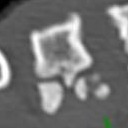

In [5]:
from IPython.display import Image

# 変更することができます
low_res_img_file_name = "ctscan.jpg"

# 元の画像を表示します。
Image(filename=low_res_img_file_name, width=632, height=632)

次に、エンドポイントへのクエリと、レスポンスのパース、生成された画像を表示するための helper関数を記述します。

In [6]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, payload, content_type, accept):
    """Query the model predictor."""

    query_response = model_predictor.predict(
        payload,
    )
    return query_response

def query_endpoint(payload):
    """query the endpoint with the json payload encoded in utf-8 format."""
    
    client = boto3.client('runtime.sagemaker')
    response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/json;jpeg', Accept = 'application/json;jpeg', Body=payload)
    return response

def parse_response(query_response):
    """Parse response and return the generated images and prompt."""

    response_dict = json.loads(query_response['Body'].read())

    return response_dict["generated_images"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display the generated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

---
以下に、低解像度の画像とプロンプトの例を示します。任意のテキストと画像を入力でき、モデルはアップスケールした画像を生成します。元の画像の 4 倍のサイズの画像を生成することに注意してください。非常に大きな画像を入力すると、CUDAメモリの問題が発生する可能性があります。この問題に対処するには、解像度の低い画像を入力するか、ml.g5.2xlarge のような CUDA メモリが大きいインスタンスタイプを選んでください。

---

#### サポートされるパラメータ

***
このモデルは、推論を実行する際に以下に示す多くのパラメータをサポートします。

* **prompt**: 画像生成をガイドするプロンプトです。文字列または文字列のリストを指定する必要があります。
* **num_inference_steps**: 画像生成時のノイズ除去ステップ数です。ステップ数が多いほど高画質になります。正の整数である必要があります。
* **guidance_scale**: 大きい値を指定すると画質が犠牲にする代わりに、プロンプトに近い画像を生成します。1 以下の guidance_scale は無視されます。
* **negative_prompt**: このプロンプトに反する様に画像生成をガイドします。文字列または文字列のリストである必要があり、guidance_scaleと共に使用されます。guidance_scaleが無効の場合、negative_promptも無効になります。さらに、promptが文字列のリストである場合、nagetive_promptも文字列のリストである必要があります。 
* **seed**: 再現性のために、ランダム化された状態を固定します。指定する場合、整数である必要があります。
* **noise_level**: アップスケールする前に潜在ベクトルにノイズを加えます。指定する場合、整数である必要があります。

***

In [7]:
import base64
from PIL import Image
from io import BytesIO


# content_type = 'application/json;jpeg' を指定します。エンドポイントは、
# 低解像度の jpeg 画像を base64.b64 形式でエンコードしたバイト列を含む json を payload として受け取ります。
# raw画像をエンドポイントに送信するには、content_type = 'application/json' を指定し、
# encoded_image に np.array(PIL.Image.open('low_res_image.jpg')).tolist() を設定します。
content_type = "application/json;jpeg"


# 低解像度画像の高さと幅が 2 の累乗となるように、画像を再スケーリングすることをお勧めします。
# original_image = Image.open('low_res_image.jpg')
# rescaled_image = original_image.rescale((128,128))
# rescaled_image.save('rescaled_image.jpg')
# のように処理できます。
# このチュートリアルで使用するサンプル画像のサイズは 128x128 です。
with open(low_res_img_file_name, "rb") as f:
    low_res_image_bytes = f.read()
encoded_image = base64.b64encode(bytearray(low_res_image_bytes)).decode()
print(encoded_image)

payload = {
    "prompt": "xray ct scan",
    "image": encoded_image,
    "num_inference_steps": 500,
    "guidance_scale": 7.5,
}

# accept = 'application/json;jpeg'の場合、エンドポイントはjpeg画像をbase64.b64形式でエンコードしたバイト列として返します。
# raw 画像を rgb 値で受け取る場合、accept = 'application/json' をセットします。
accept = "application/json;jpeg"

/9j/4AAQSkZJRgABAQAASABIAAD/4QBMRXhpZgAATU0AKgAAAAgAAgESAAMAAAABAAEAAIdpAAQAAAABAAAAJgAAAAAAAqACAAQAAAABAAAAgKADAAQAAAABAAAAgAAAAAD/7QA4UGhvdG9zaG9wIDMuMAA4QklNBAQAAAAAAAA4QklNBCUAAAAAABDUHYzZjwCyBOmACZjs+EJ+/+IB2ElDQ19QUk9GSUxFAAEBAAAByAAAAAAEMAAAbW50clJHQiBYWVogB+AAAQABAAAAAAAAYWNzcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPbWAAEAAAAA0y0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJZGVzYwAAAPAAAAAkclhZWgAAARQAAAAUZ1hZWgAAASgAAAAUYlhZWgAAATwAAAAUd3RwdAAAAVAAAAAUclRSQwAAAWQAAAAoZ1RSQwAAAWQAAAAoYlRSQwAAAWQAAAAoY3BydAAAAYwAAAA8bWx1YwAAAAAAAAABAAAADGVuVVMAAAAIAAAAHABzAFIARwBCWFlaIAAAAAAAAG+iAAA49QAAA5BYWVogAAAAAAAAYpkAALeFAAAY2lhZWiAAAAAAAAAkoAAAD4QAALbPWFlaIAAAAAAAAPbWAAEAAAAA0y1wYXJhAAAAAAAEAAAAAmZmAADypwAADVkAABPQAAAKWwAAAAAAAAAAbWx1YwAAAAAAAAABAAAADGVuVVMAAAAgAAAAHABHAG8AbwBnAGwAZQAgAEkAbgBjAC4AIAAyADAAMQA2/8AAEQgAgACAAwEiAAIRAQMRAf/EAB8AAAEFAQEBAQEBAAAAAAAAAAABAgMEBQYHCAkKC//EALUQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYn

In [8]:
# raw/rgb 値でペイロードを送受信すると、SageMaker の入力ペイロードとレスポンスのサイズの制限に当たる可能性があることに注意してください。
query_response = query_endpoint(json.dumps(payload).encode('utf-8'))
generated_images, prompt = parse_response(query_response)

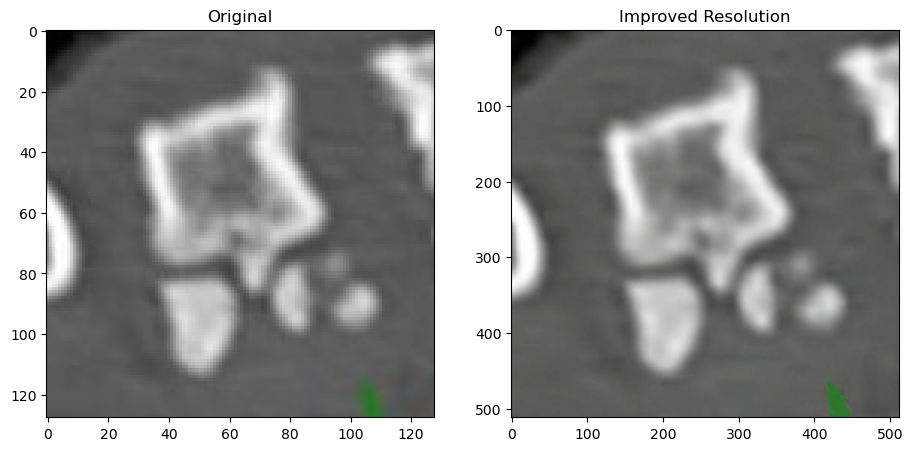

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# 図形サイズのオプション
rcParams['figure.figsize'] = 11 ,8

# 上で言及したように accept = 'application/json;jpeg' のため、画像は base64.b64 形式でエンコードされたバイト列の jpeg です。
# ここでは、画像をデコードし表示します。
for generated_image in generated_images:
    generated_image_decoded = BytesIO(base64.b64decode(generated_image.encode()))
    generated_image_rgb = Image.open(generated_image_decoded).convert("RGB")

    img_enhanced_name = 'upscaled_ctscan.jpg'
    generated_image_rgb.save(img_enhanced_name)
    # read images
    img_original = mpimg.imread(low_res_img_file_name)
    img_enhanced = mpimg.imread(img_enhanced_name)

    # display images
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img_original)
    ax[0].title.set_text('Original')
    ax[1].imshow(img_enhanced)
    ax[1].title.set_text('Improved Resolution')
    

### 4. エンドポイントのクリーンアップ

***
ノートブックを完了したら、コストの発生を停止するため、作成された全てのリソースが削除されたことを確認してください。
***

In [12]:
# SageMaker endpoint の削除
model_predictor.delete_model()
model_predictor.delete_endpoint()

[02/05/25 16:51:53] INFO     Deleting model with name:                                              ]8;id=476319;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=519928;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#5226\5226]8;;\
                             stable-diffusion-x4-upscaler-fp16-2025-02-05-14-16-06-936                             

                    INFO     Deleting endpoint configuration with name:                             ]8;id=41797;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=760925;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4865\4865]8;;\
                             medical-example-model-upscaling-stabili-2025-02-05-14-16-06-919                       

                    INFO     Deleting endpoint with name:                                           ]8;id=779374;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=731278;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4855\4855]8;;\
                             medical-example-model-upscaling-stabili-2025-02-05-14-16-06-919                       